## '2022년도 JB금융지주 데이터 분석 경진대회 - JB8

## [임시] **온라인 커머스 상품 재구매 예측 모형 개발**

### Table of Contents


**Ⅰ.Abstract**\
**Ⅱ. Introduction**
1. Required packages import
2. Data import
3. Exploratory data analysis
**Ⅲ. Methods**
1. Data preprocessing
2. Modeling
3. Model validation
**Ⅳ. Results**


### Ⅰ. **Abstract**

### Ⅱ. **Introduction**

#### 1. Required packages import

In [1]:
from jbfg.pandas_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
 
import warnings 

In [2]:
schema = 'l2_jbbk_extnl' 

#### 2. Data import

In [3]:
sql = 'select * from products_info'
sql2 = 'select * from train_x_past'
sql3 = 'select * from train_x_current'
sql4 = 'select * from train_y'
sql5 = 'select * from test_x_past'
sql6 = 'select * from test_x_current'

In [4]:
%%time
products_info = get_df(sql, schema)
train_x_past = get_df(sql2, schema)
train_x_current = get_df(sql3, schema)
train_y = get_df(sql4, schema)
test_x_past = get_df(sql5, schema)
test_x_current = get_df(sql6, schema)

CPU times: user 13 s, sys: 1.13 s, total: 14.2 s
Wall time: 13.1 s


#### 2.1 Dataset description
- **Products_info** : 100개 상품에 대한 정보\
  **Train_x_past** : 5,859명 고객들의 과거 구매 이력\
   **Train_x_current** : 상품 ID를 제외한 5,859명 고객들의 현재 구매 정보\
   **Train_y** : 5,859명 고객들의 현재 주문 정보에 대한 상품 ID\
   **Test_x_past** : 4,141명 고객들의 과거 구매 이력\
   **Test_x_current** : 상품ID를 제외한 4,144명 고객들의 현재 구매 정보

+ Dataset dimension 확인

In [5]:
print(f""" products_info : {products_info.shape} \n train_x_past : {train_x_past.shape} \n train_x_current : {train_x_current.shape} \n train_y : {train_y.shape} \n test_x_past : {test_x_past.shape} \n test_x_current : {test_x_current.shape} """)

 products_info : (100, 6) 
 train_x_past : (1253972, 9) 
 train_x_current : (24424, 8) 
 train_y : (24424, 1) 
 test_x_past : (541922, 9) 
 test_x_current : (16126, 8) 


- **Products_info** : 상품정보 [상품ID, 상품명, 분류 ID, 담당부서 ID, 분류명, 담당부서명]

In [6]:
products_info.tail()

,product_id,name,category_id,division_id,category_name,division_name
95,47209,Organic Hass Avocado,24,4,fresh fruits,produce
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
97,21137,Organic Strawberries,24,4,fresh fruits,produce
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce
99,24852,Banana,24,4,fresh fruits,produce


In [7]:
products_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     100 non-null    object
 1   name           100 non-null    object
 2   category_id    100 non-null    object
 3   division_id    100 non-null    object
 4   category_name  100 non-null    object
 5   division_name  100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB


- **Train_x_past** : 5,859명 고객의 과거 구매 이력 [주문 ID, 고객 ID, 고객별 주문순서, 구매요일, 구매시각, 직전 구매 후 경과일수, 주문서 내 담긴 상품의 순번, 재구매여부, 상품 ID]

In [8]:
train_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
1253967,1902783,163819,47,0,19,13.0,2,1,24852
1253968,1969590,163819,42,1,15,6.0,3,1,24852
1253969,2549215,163819,9,1,11,7.0,1,1,24852
1253970,3103211,163819,39,1,14,7.0,3,1,24852
1253971,3207262,163819,8,1,12,7.0,1,1,24852


In [9]:
train_x_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
dtypes: object(9)
memory usage: 86.1+ MB


- **Train_x_current** : 5,859명 고객들의 최근 주문 번호 [주문 ID, 고객 ID, 고객별 주문순서, 구매요일, 구매시각, 직전 구매 후 경과일수, 주문서 내 담긴 상품의 순번, 재구매여부]

In [10]:
train_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
24419,3184000,174046,100,5,7,2.0,12,1
24420,1754722,6710,100,5,11,3.0,21,1
24421,1076973,150840,100,0,13,0.0,18,1
24422,1247049,99707,100,1,13,3.0,6,1
24423,1775787,201038,100,5,9,2.0,1,1


In [11]:
train_x_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        24424 non-null  object
 1   cstno           24424 non-null  object
 2   order_number    24424 non-null  object
 3   week_day        24424 non-null  object
 4   order_hour      24424 non-null  object
 5   order_interval  24424 non-null  object
 6   add_order       24424 non-null  object
 7   is_reordered    24424 non-null  object
dtypes: object(8)
memory usage: 1.5+ MB


- **train_y** : 5,859명 고객들의 최근 주문 상품 (train_x_current의 각 열에 매칭되는 상품 정보)

In [12]:
train_y.tail()

,product_id
24419,24852
24420,24852
24421,24852
24422,24852
24423,24852


In [13]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  24424 non-null  object
dtypes: object(1)
memory usage: 190.9+ KB


- **test_x_past** : 4,141명 고객들의 과거 구매 이력 [주문 ID, 고객 ID, 고객별 주문순서, 구매요일, 구매시각, 직전 구매 후 경과일수, 주문서 내 담긴 상품의 순번, 재구매여부, 상품 ID]

In [14]:
test_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
541917,2672845,119134,39,1,14,17.0,4,1,24852
541918,2731678,119134,38,5,14,3.0,4,1,24852
541919,2860406,119134,9,5,9,8.0,1,1,24852
541920,3252013,119134,4,5,10,7.0,2,1,24852
541921,3275894,119134,16,4,10,3.0,10,1,24852


In [15]:
test_x_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541922 entries, 0 to 541921
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   order_id        541922 non-null  object
 1   cstno           541922 non-null  object
 2   order_number    541922 non-null  object
 3   week_day        541922 non-null  object
 4   order_hour      541922 non-null  object
 5   order_interval  541922 non-null  object
 6   add_order       541922 non-null  object
 7   is_reordered    541922 non-null  object
 8   product_id      541922 non-null  object
dtypes: object(9)
memory usage: 37.2+ MB


- **test_x_current** : 4,141명 고객들의 미래 주문 정보 [주문 ID, 고객 ID, 고객별 주문순서, 구매요일, 구매시각, 직전 구매 후 경과일수, 주문서 내 담긴 상품의 순번, 재구매여부]

In [16]:
test_x_current.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
16121,2047884,57077,46,5,15,8.0,2,1
16122,567625,83592,43,4,12,0.0,1,1
16123,596442,157740,49,6,10,3.0,2,1
16124,671102,92043,43,4,10,10.0,1,1
16125,529654,62871,58,4,8,8.0,22,1


In [17]:
test_x_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        16126 non-null  object
 1   cstno           16126 non-null  object
 2   order_number    16126 non-null  object
 3   week_day        16126 non-null  object
 4   order_hour      16126 non-null  object
 5   order_interval  16126 non-null  object
 6   add_order       16126 non-null  object
 7   is_reordered    16126 non-null  object
dtypes: object(8)
memory usage: 1008.0+ KB


In [18]:
train_x_past = train_x_past.merge(products_info, on = 'product_id', how = 'left')
train_x_past["set"] = 'train'

test_x_past = test_x_past.merge(products_info, on = 'product_id', how = 'left')
test_x_past["set"] = 'test'

In [19]:
past_data = pd.concat([train_x_past, test_x_past], ignore_index = True)
len(set(past_data.cstno))

10000

In [20]:
past_data.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name,set
0,717029,196613,15,1,9,3.0,5,0,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce,train
1,2325772,196613,35,6,11,2.0,7,1,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce,train
2,642668,196613,69,2,16,2.0,11,1,4210,Whole Milk,84,16,milk,dairy eggs,train
3,1326515,196613,61,3,19,3.0,3,1,4210,Whole Milk,84,16,milk,dairy eggs,train
4,1437845,196613,36,3,15,4.0,16,0,4210,Whole Milk,84,16,milk,dairy eggs,train


### 3. Exploratory data analysis

#### 3.1 Customer 관점

- Train/Test set의 주문 수 비중

<function matplotlib.pyplot.show(*args, **kw)>

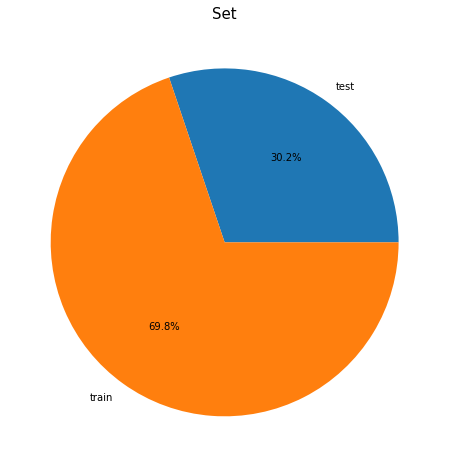

In [21]:
set_data = past_data.groupby('set')['order_id'].count() 
labels = pd.DataFrame(set_data).reset_index(drop=False).set 
plt.figure(figsize=(8,8)) 
plt.pie(set_data, labels = labels, autopct = '%.1f%%') 
plt.title('Set', fontsize = 15) 
plt.show 

- 요일별 고객의 주문 수 비중

Text(0.5, 1.0, 'Number of Orders per Day of Week')

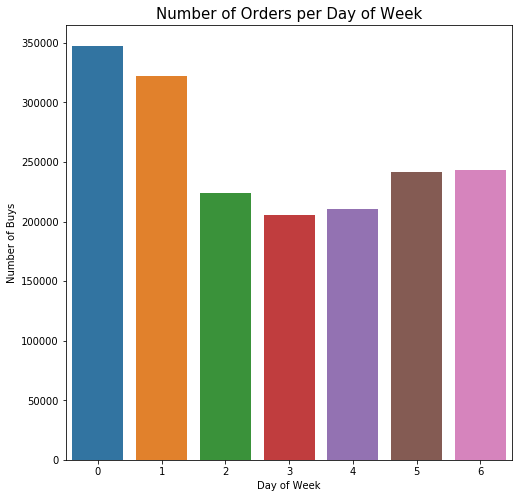

In [22]:
week_day = past_data.groupby('week_day')['order_id'].count() 
week_day = pd.DataFrame(week_day).reset_index(drop=False) 
plt.figure(figsize=(8,8)) 
sns.barplot(x = 'week_day', y = 'order_id' , data = week_day) 
plt.ylabel('Number of Buys', fontsize = 10) 
plt.xlabel('Day of Week', fontsize = 10) 
plt.title('Number of Orders per Day of Week', fontsize = 15) 

- 시간별 주문 수 분포

Text(0.5, 1.0, 'Number of Orders per Hour of Week')

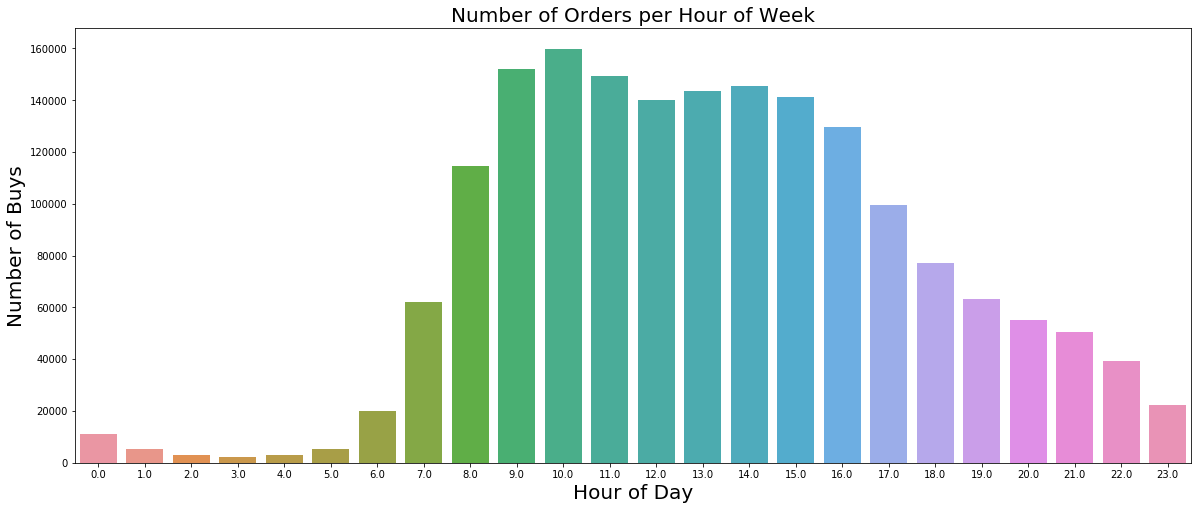

In [23]:
past_data['order_hour'] = past_data['order_hour'].astype('float') 
 
order_hour = past_data.groupby('order_hour')['order_id'].count() 
order_hour = pd.DataFrame(order_hour).reset_index(drop=False)
plt.figure(figsize=(20,8)) 
sns.barplot(x = 'order_hour', y = 'order_id' , data = order_hour) 
plt.ylabel('Number of Buys', fontsize = 20) 
plt.xlabel('Hour of Day', fontsize = 20) 
plt.title('Number of Orders per Hour of Week', fontsize = 20) 

- 요일 및 시간에 따른 주문 빈도

Text(0.5, 51.0, 'Hour of Day')

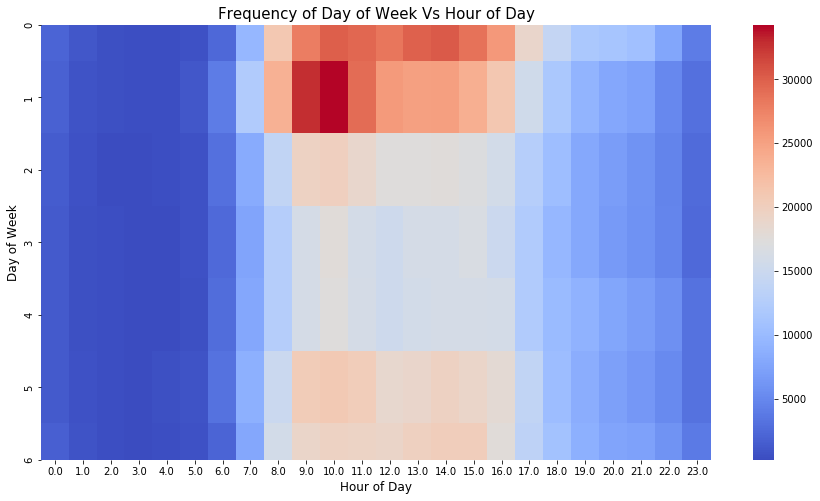

In [24]:
days_hours = past_data.groupby(['week_day','order_hour'])['order_number'].agg('count').reset_index() 
days_hours = days_hours.pivot('week_day', 'order_hour', 'order_number') 

plt.figure(figsize=(15,8)) 
sns.heatmap(days_hours, cmap = 'coolwarm') 
plt.title('Frequency of Day of Week Vs Hour of Day', fontsize = 15) 
plt.ylabel('Day of Week', fontsize = 12) 
plt.xlabel('Hour of Day', fontsize = 12) 


- 고객당 주문 횟수의 분포

In [25]:
warnings.filterwarnings('ignore', category = FutureWarning) 

<function matplotlib.pyplot.show(*args, **kw)>

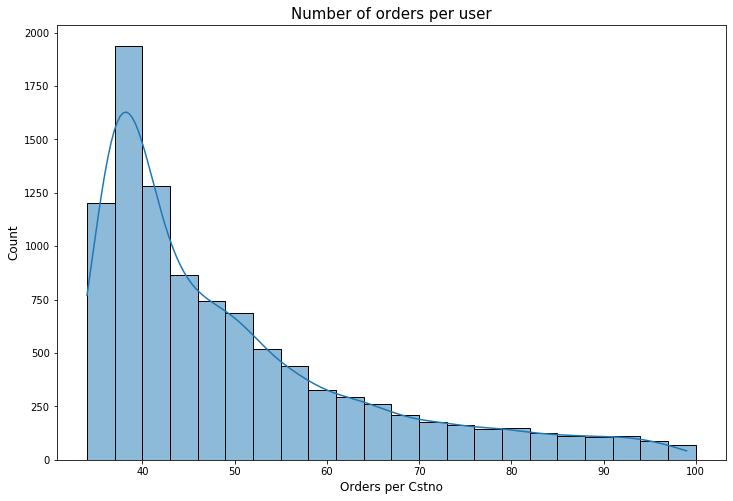

In [26]:
plt.figure(figsize = (12,8)) 
sns.histplot(past_data.groupby('cstno')['order_id'].nunique(), binwidth=3, kde = True, palette = 'Set2') 
plt.title('Number of orders per user', fontsize = 15) 
plt.ylabel('Count', fontsize = 12) 
plt.xlabel('Orders per Cstno', fontsize = 12) 
plt.show

- 재구매비율

In [27]:
prop_reorder = past_data.groupby('is_reordered')['order_id'].count().reset_index() 
prop_reorder['proportion'] = prop_reorder['order_id'] * 100 / past_data['order_id'].count() 

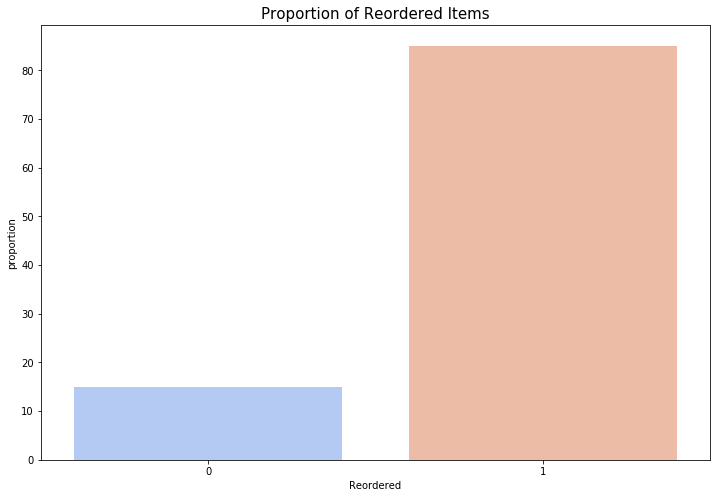

In [28]:
plt.figure(figsize = (12,8)) 
sns.barplot(data = prop_reorder, x='is_reordered', y = 'proportion', palette = 'coolwarm') 
plt.ylabel('proportion', fontsize = 10) 
plt.xlabel('Reordered', fontsize = 10) 
plt.title('Proportion of Reordered Items', fontsize = 15) 
plt.show(); 

#### 3.2 Product 관점

<function matplotlib.pyplot.show(*args, **kw)>

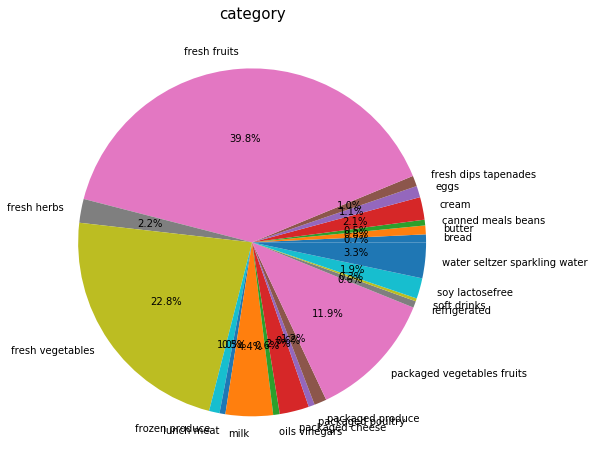

In [29]:
category_data = past_data.groupby('category_name')['order_id'].count() 
labels = pd.DataFrame(category_data).reset_index(drop=False).category_name 
plt.figure(figsize=(8,8)) 
plt.pie(category_data, labels = labels, autopct = '%.1f%%') 
plt.title('category', fontsize = 15) 
plt.show 

- Product co-purchasing network 

In [30]:
net_past_dat = past_data[["order_id","division_name"]].sort_values(by="order_id").reset_index(drop='True')

In [31]:
matrix = pd.get_dummies(net_past_dat.set_index('order_id')['division_name'].astype(str)).max(level=0).sort_index()

In [32]:
matrix_0 = np.asmatrix(matrix)

In [33]:
t_matrix = matrix_0.transpose()

In [34]:
f_matrix = t_matrix.dot(matrix)
network_table = pd.DataFrame(f_matrix)

In [35]:
network_table

,0,1,2,3,4,5,6,7,8
0,139,192,10,39,132,58,167,68,146
1,192,202,183,198,22,212,61,83,2
2,10,183,39,76,230,173,195,46,160
3,39,198,76,115,120,3,85,143,70
4,132,22,230,120,214,162,115,5,65
5,58,212,173,3,162,23,248,144,105
6,167,61,195,85,115,248,188,16,57
7,68,83,46,143,5,144,16,106,165
8,146,2,160,70,65,105,57,165,72


In [36]:
name = list(net_past_dat.division_name.unique())
name.sort()
network_table.index = name
network_table.columns = name

In [37]:
graph = nx.from_pandas_adjacency(network_table)

In [38]:
combs = {}
adjc = graph.adj
for i in adjc:
    suba = adjc[i]
    for j in suba:
        combs[(i,j)] = suba[j]['weight']

CPU times: user 18.7 ms, sys: 68 µs, total: 18.8 ms
Wall time: 18.1 ms


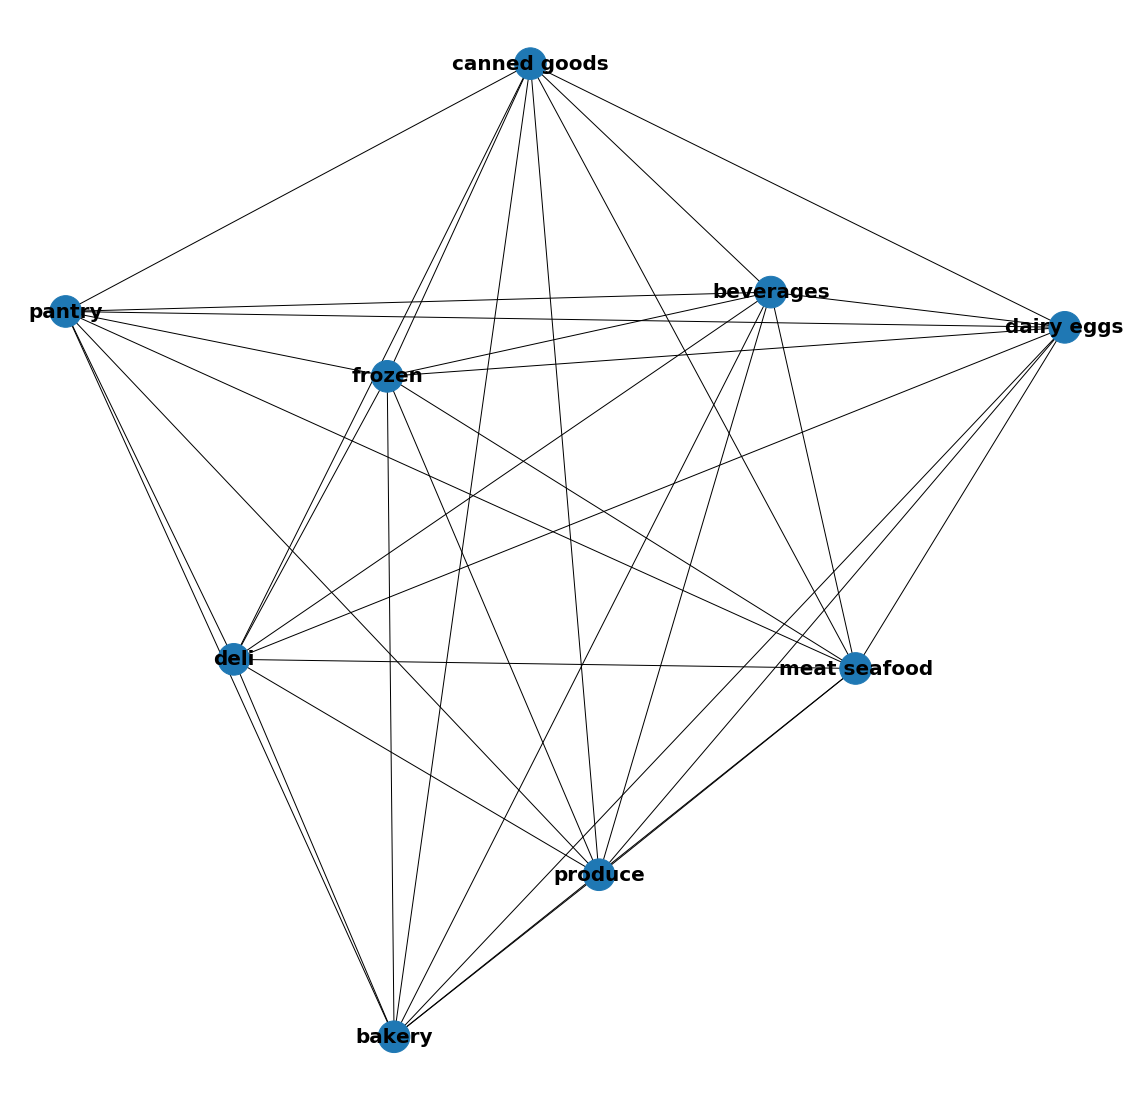

In [39]:
%%time
plt.subplots(figsize=(20,20))
layout = nx.spring_layout(graph)
d = dict(graph.degree)
nx.draw(graph,pos=layout,with_labels='True',font_size=20,font_weight='bold',node_size=[v*100 for v in d.values()])